In [1]:
import logging
# set seed
from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
import evaluation as ev
from pathlib import *
import torch
import random
import regex as re
import plot
import matplotlib.pyplot as plt
from sk_models import LocalWeightedRegression, PCR,setup_pls_models_exh,LinearRidge
import seaborn as sns


In [2]:
seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)

random_state = np.random.RandomState(seed)

In [3]:
#we need to set parametesr
file_name ="A_C_OF_alpha.csv"# "A_AL_RT.csv" #"PLN7.csv"
id_cols =["sample_id"] ##["db_id","sample_id"]#["sample_id"]
n_comps = [i*5 for i in range(1,21)]

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/0.01")

In [4]:
data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)

data = pd.read_csv(data_file)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)

n_features = ncol - 1-len(id_cols)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)

# todo write a summary
#ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
#tb = SummaryWriter(log_dir/"tb")
print(log_dir)

D:\workspace\lazydeep\experiments\0.01\A_C_OF_alpha
D:\workspace\lazydeep\experiments\0.01\A_C_OF_alpha


In [5]:
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
eval = ev.CrossValEvaluation(preprocessing=None,tensorboard=None,time=True,random_state=random_state)

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [6]:
def plot_preds_and_res(preds,save_loc = "", name_lambda = lambda x:x,save_lambda = lambda x:x):
    for col_name in preds.columns:
        # plot predictions
        fig, ax = plot.scatter_plot(preds,col_name,"y",color_col="set_id",title= f"Predictions for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"predictions_{save_lambda(col_name)}.png",bbox_inches='tight')
        plt.close()
        # plt.show()

        fig, ax = plot.residual_plot(preds, col_name, "y", color_col="set_id",title = f"Residuals for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"residuals_{save_lambda(col_name)}.png", bbox_inches='tight')
        plt.close()

In [7]:
#setup
scores_df_pcr = None
scores_df_pcr_final = None
for n_component in n_comps:
    save_loc = log_dir/f"PCR_{n_component}"
    if not save_loc.exists():
        save_loc.mkdir()

    local_logger_name = f"pcr_{n_component}"
    ut.setup_logger(logger_name=local_logger_name,file_name=save_loc/f"{local_logger_name}_log.txt")
    local_logger = logging.getLogger(local_logger_name)

    scheme = ev.PCAScheme(logger=local_logger_name,whiten=False,n_components=n_component)

    local_logger.info(f"Running PCR with {n_component} components")
    scores_sk, preds_sk, model_states_sk , train_time_sk, test_time_sk,_ = eval.evaluate(setup_pls_models_exh(nrow),dataset,scheme,logger_name=local_logger_name)
    scores_sk_final, _, model_states_sk_final , _, _,_= eval.build(setup_pls_models_exh(nrow),dataset,scheme,logger_name=local_logger_name)
    #for fold,nested in model_states_sk.items():
    ##    for name,model in nested.items():
    #        CustomWrapper(None).save_state(model,save_loc/(f"{name}_{fold}"))
    #for name,model in model_states_sk_final.items():
    #    model.save_state(model.state(),save_loc/(f"{name}_final"))

    local_logger.info(f"Train times: {train_time_sk}")
    local_logger.info(f"Test times: {test_time_sk}")
    local_logger.info(f"Scores: {scores_sk}")
    for key,value in ut.flip_dicts(scores_sk).items():
        local_logger.info(f"{key}: {value}")

    preds_sk.to_csv(save_loc/ (f"predictions_pcr" + ".csv"), index=False)
    plot_preds_and_res(preds_sk,name_lambda=lambda x:f"PCR with {x} components",save_lambda= lambda x:f"pcr_{x}",save_loc=save_loc)

    flipped = ut.flip_dicts(scores_sk)
    #add to scores
    for name,record in flipped.items():
        record1 = {'model':f"pca_{name}",'n_comp':n_component}
        if scores_df_pcr is None:
            scores_df_pcr =pd.DataFrame([{**record1,**record}])
        else:
           scores_df_pcr=scores_df_pcr.append([{**record1,**record}],ignore_index=True)

    flipped = ut.flip_dicts(scores_sk_final)
    #add to scores
    for name,record in flipped.items():
        record1 = {'model':f"pca_{name}",'n_comp':n_component}
        if scores_df_pcr_final is None:
            scores_df_pcr_final =pd.DataFrame([{**record1,**record}])
        else:
           scores_df_pcr_final=scores_df_pcr_final.append([{**record1,**record}],ignore_index=True)

Running PCR with 5 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:123.0969,lwr_k=10:26.3916,lwr_k=20:41.0668,lwr_k=30:45.7526,lwr_k=40:47.9323,lwr_k=50:49.5357,lwr_k=100:56.1003,lwr_k=200:63.8601,lwr_k=300:69.5056,lwr_k=400:73.6958,lwr_k=500:78.0744,lwr_k=600:81.5082,lwr_k=700:84.232,lwr_k=800:87.0369,lwr_k=900:89.7387,lwr_k=1000:91.8461'
Tested (test) on 1222 instances with mean losses of: lr:149.8386,lwr_k=10:126.7886,lwr_k=20:71.5422,lwr_k=30:68.2443,lwr_k=40:65.3517,lwr_k=50:66.1105,lwr_k=100:73.1165,lwr_k=200:80.4677,lwr_k=300:86.8141,lwr_k=400:92.3913,lwr_k=500:97.8947,lwr_k=600:101.0341,lwr_k=700:105.1258,lwr_k=800:108.4559,lwr_k=900:111.5402,lwr_k=1000:113.908'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 10 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:56.1634,lwr_k=10:0.0,lwr_k=20:4.8657,lwr_k=30:7.2122,lwr_k=40:8.5808,lwr_k=50:10.1129,lwr_k=100:13.6781,lwr_k=200:18.6172,lwr_k=300:22.0693,lwr_k=400:24.5727,lwr_k=500:26.7749,lwr_k=600:28.7268,lwr_k=700:30.3445,lwr_k=800:31.793,lwr_k=900:33.2028,lwr_k=1000:34.5738'
Tested (test) on 1222 instances with mean losses of: lr:78.1876,lwr_k=10:395.9612,lwr_k=20:28.6033,lwr_k=30:21.3894,lwr_k=40:21.264,lwr_k=50:21.5509,lwr_k=100:25.329,lwr_k=200:30.5967,lwr_k=300:34.8089,lwr_k=400:38.8919,lwr_k=500:42.7248,lwr_k=600:45.7086,lwr_k=700:47.4804,lwr_k=800:49.3085,lwr_k=900:50.9514,lwr_k=1000:52.3893'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:77.515,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 15 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:47.9093,lwr_k=10:0.0,lwr_k=20:1.4377,lwr_k=30:3.6583,lwr_k=40:4.9651,lwr_k=50:6.0609,lwr_k=100:9.4999,lwr_k=200:13.5204,lwr_k=300:16.1014,lwr_k=400:17.7847,lwr_k=500:19.4642,lwr_k=600:20.9155,lwr_k=700:22.2055,lwr_k=800:23.323,lwr_k=900:24.5645,lwr_k=1000:25.6053'
Tested (test) on 1222 instances with mean losses of: lr:69.2937,lwr_k=10:44.7033,lwr_k=20:43.5757,lwr_k=30:21.276,lwr_k=40:19.1755,lwr_k=50:17.5433,lwr_k=100:21.1493,lwr_k=200:27.0666,lwr_k=300:30.4467,lwr_k=400:32.8598,lwr_k=500:35.2641,lwr_k=600:37.3418,lwr_k=700:38.8226,lwr_k=800:40.3579,lwr_k=900:41.8267,lwr_k=1000:42.8583'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:66.91,lwr_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 20 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:43.1105,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:1.9849,lwr_k=40:3.1929,lwr_k=50:4.0329,lwr_k=100:6.7142,lwr_k=200:10.1536,lwr_k=300:12.6402,lwr_k=400:14.3091,lwr_k=500:15.9708,lwr_k=600:17.455,lwr_k=700:18.7582,lwr_k=800:19.9643,lwr_k=900:21.1512,lwr_k=1000:22.206'
Tested (test) on 1222 instances with mean losses of: lr:60.947,lwr_k=10:33.347,lwr_k=20:703.1726,lwr_k=30:34.8685,lwr_k=40:21.524,lwr_k=50:17.6782,lwr_k=100:17.567,lwr_k=200:21.009,lwr_k=300:24.0169,lwr_k=400:26.1203,lwr_k=500:28.5551,lwr_k=600:30.8132,lwr_k=700:32.6046,lwr_k=800:34.0909,lwr_k=900:35.301,lwr_k=1000:36.0809'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:61.9656,lwr_k=10:0.0,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 25 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:39.7616,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.7359,lwr_k=40:2.1177,lwr_k=50:2.9854,lwr_k=100:5.4391,lwr_k=200:8.267,lwr_k=300:10.3841,lwr_k=400:11.8252,lwr_k=500:13.2331,lwr_k=600:14.3049,lwr_k=700:15.29,lwr_k=800:16.2795,lwr_k=900:17.2575,lwr_k=1000:18.1898'
Tested (test) on 1222 instances with mean losses of: lr:55.0311,lwr_k=10:29.854,lwr_k=20:46.2587,lwr_k=30:51.3693,lwr_k=40:26.9868,lwr_k=50:18.2964,lwr_k=100:14.7938,lwr_k=200:17.2943,lwr_k=300:19.9123,lwr_k=400:21.4379,lwr_k=500:22.9483,lwr_k=600:24.1719,lwr_k=700:25.8442,lwr_k=800:26.7989,lwr_k=900:27.5393,lwr_k=1000:28.2968'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:54.1738,lwr_k=10:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 30 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:37.1916,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:1.3383,lwr_k=50:2.1724,lwr_k=100:4.7441,lwr_k=200:7.2173,lwr_k=300:9.144,lwr_k=400:10.3039,lwr_k=500:11.5155,lwr_k=600:12.5808,lwr_k=700:13.6454,lwr_k=800:14.5108,lwr_k=900:15.482,lwr_k=1000:16.3937'
Tested (test) on 1222 instances with mean losses of: lr:51.1266,lwr_k=10:29.6677,lwr_k=20:33.4949,lwr_k=30:1112.0223,lwr_k=40:36.8464,lwr_k=50:23.4543,lwr_k=100:14.8393,lwr_k=200:15.3228,lwr_k=300:17.2288,lwr_k=400:18.3833,lwr_k=500:19.5976,lwr_k=600:20.9247,lwr_k=700:22.4892,lwr_k=800:23.4902,lwr_k=900:24.3489,lwr_k=1000:25.2006'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:50.5679,lwr_k=10:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 35 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:35.759,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.4701,lwr_k=50:1.4422,lwr_k=100:4.1056,lwr_k=200:6.6437,lwr_k=300:8.5209,lwr_k=400:9.7121,lwr_k=500:10.965,lwr_k=600:12.0646,lwr_k=700:13.0785,lwr_k=800:13.9873,lwr_k=900:14.9257,lwr_k=1000:15.8494'
Tested (test) on 1222 instances with mean losses of: lr:48.1634,lwr_k=10:28.0358,lwr_k=20:32.0618,lwr_k=30:76.5733,lwr_k=40:70.5027,lwr_k=50:27.7695,lwr_k=100:15.2688,lwr_k=200:15.3067,lwr_k=300:17.4418,lwr_k=400:18.891,lwr_k=500:19.862,lwr_k=600:21.053,lwr_k=700:22.5552,lwr_k=800:23.4349,lwr_k=900:24.1195,lwr_k=1000:24.9128'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:48.5641,lwr_k=10:0.0,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 40 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:31.8306,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.9635,lwr_k=100:3.6996,lwr_k=200:6.0942,lwr_k=300:7.8543,lwr_k=400:9.0598,lwr_k=500:10.222,lwr_k=600:11.3147,lwr_k=700:12.2587,lwr_k=800:13.1122,lwr_k=900:14.0485,lwr_k=1000:14.8822'
Tested (test) on 1222 instances with mean losses of: lr:43.9988,lwr_k=10:27.8041,lwr_k=20:27.9183,lwr_k=30:50.2163,lwr_k=40:1367.8068,lwr_k=50:45.8146,lwr_k=100:15.3367,lwr_k=200:15.2315,lwr_k=300:16.5724,lwr_k=400:17.7286,lwr_k=500:18.7169,lwr_k=600:19.8477,lwr_k=700:21.1376,lwr_k=800:21.9448,lwr_k=900:22.8613,lwr_k=1000:23.5594'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:43.0309,lwr_k=10:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 45 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:30.6439,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.3756,lwr_k=100:3.2289,lwr_k=200:5.7675,lwr_k=300:7.4876,lwr_k=400:8.692,lwr_k=500:9.8297,lwr_k=600:10.8652,lwr_k=700:11.7748,lwr_k=800:12.5866,lwr_k=900:13.4391,lwr_k=1000:14.2668'
Tested (test) on 1222 instances with mean losses of: lr:42.883,lwr_k=10:28.3018,lwr_k=20:25.5072,lwr_k=30:39.2085,lwr_k=40:67.316,lwr_k=50:104.2507,lwr_k=100:16.3868,lwr_k=200:15.1298,lwr_k=300:16.3045,lwr_k=400:17.5602,lwr_k=500:18.7549,lwr_k=600:19.7382,lwr_k=700:20.8833,lwr_k=800:21.667,lwr_k=900:22.657,lwr_k=1000:23.3951'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:39.8132,lwr_k=10:0.0,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 50 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:28.765,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:2.735,lwr_k=200:5.3316,lwr_k=300:7.0386,lwr_k=400:8.2633,lwr_k=500:9.4229,lwr_k=600:10.4429,lwr_k=700:11.3524,lwr_k=800:12.1608,lwr_k=900:12.9896,lwr_k=1000:13.7701'
Tested (test) on 1222 instances with mean losses of: lr:40.1218,lwr_k=10:27.8485,lwr_k=20:24.1639,lwr_k=30:30.6258,lwr_k=40:47.9197,lwr_k=50:5005.4108,lwr_k=100:17.4702,lwr_k=200:15.4001,lwr_k=300:16.1682,lwr_k=400:17.1368,lwr_k=500:18.1702,lwr_k=600:19.1784,lwr_k=700:20.3301,lwr_k=800:21.0707,lwr_k=900:21.968,lwr_k=1000:22.5673'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:38.9616,lwr_k=10:0.0,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 55 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:26.4332,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:2.3149,lwr_k=200:4.8871,lwr_k=300:6.4023,lwr_k=400:7.6567,lwr_k=500:8.7774,lwr_k=600:9.6835,lwr_k=700:10.5477,lwr_k=800:11.3765,lwr_k=900:12.1241,lwr_k=1000:12.8877'
Tested (test) on 1222 instances with mean losses of: lr:36.1976,lwr_k=10:27.8283,lwr_k=20:24.148,lwr_k=30:28.1076,lwr_k=40:37.8671,lwr_k=50:82.2481,lwr_k=100:18.1545,lwr_k=200:14.9678,lwr_k=300:15.5763,lwr_k=400:16.3095,lwr_k=500:17.0034,lwr_k=600:17.8018,lwr_k=700:18.8418,lwr_k=800:19.3464,lwr_k=900:20.1124,lwr_k=1000:20.7553'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:35.2137,lwr_k=10:0.0,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 60 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:25.6688,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:2.065,lwr_k=200:4.6291,lwr_k=300:6.1941,lwr_k=400:7.3891,lwr_k=500:8.5223,lwr_k=600:9.3933,lwr_k=700:10.2152,lwr_k=800:10.9986,lwr_k=900:11.7313,lwr_k=1000:12.4546'
Tested (test) on 1222 instances with mean losses of: lr:35.1342,lwr_k=10:27.5582,lwr_k=20:24.1776,lwr_k=30:26.1069,lwr_k=40:35.941,lwr_k=50:51.3457,lwr_k=100:19.8159,lwr_k=200:15.6891,lwr_k=300:15.6517,lwr_k=400:16.1592,lwr_k=500:16.7214,lwr_k=600:17.5015,lwr_k=700:18.3999,lwr_k=800:18.8348,lwr_k=900:19.5532,lwr_k=1000:20.0922'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:34.2467,lwr_k=10:0.0,lwr_k=20:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 65 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:25.0739,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:1.7612,lwr_k=200:4.341,lwr_k=300:5.9461,lwr_k=400:7.1169,lwr_k=500:8.233,lwr_k=600:9.0637,lwr_k=700:9.8304,lwr_k=800:10.5868,lwr_k=900:11.2549,lwr_k=1000:11.9862'
Tested (test) on 1222 instances with mean losses of: lr:34.582,lwr_k=10:27.7154,lwr_k=20:22.8847,lwr_k=30:24.5391,lwr_k=40:31.9448,lwr_k=50:38.214,lwr_k=100:23.6372,lwr_k=200:15.2264,lwr_k=300:15.173,lwr_k=400:15.4314,lwr_k=500:15.9665,lwr_k=600:16.6997,lwr_k=700:17.5755,lwr_k=800:17.945,lwr_k=900:18.5809,lwr_k=1000:19.1481'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:33.5509,lwr_k=10:0.0,lwr_k=20:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 70 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:24.3868,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:1.4716,lwr_k=200:4.0009,lwr_k=300:5.6246,lwr_k=400:6.7672,lwr_k=500:7.8676,lwr_k=600:8.6639,lwr_k=700:9.433,lwr_k=800:10.1797,lwr_k=900:10.8388,lwr_k=1000:11.5417'
Tested (test) on 1222 instances with mean losses of: lr:33.5985,lwr_k=10:26.6076,lwr_k=20:22.3919,lwr_k=30:23.0587,lwr_k=40:29.837,lwr_k=50:33.2892,lwr_k=100:25.6319,lwr_k=200:15.0524,lwr_k=300:15.1324,lwr_k=400:15.3588,lwr_k=500:15.8803,lwr_k=600:16.5678,lwr_k=700:17.5169,lwr_k=800:17.8344,lwr_k=900:18.3909,lwr_k=1000:18.9314'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:32.6378,lwr_k=10:0.0,lwr_k=20:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 75 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:23.5604,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:1.1504,lwr_k=200:3.7587,lwr_k=300:5.2553,lwr_k=400:6.3601,lwr_k=500:7.4929,lwr_k=600:8.2074,lwr_k=700:8.9928,lwr_k=800:9.7266,lwr_k=900:10.402,lwr_k=1000:11.0994'
Tested (test) on 1222 instances with mean losses of: lr:33.1227,lwr_k=10:30.4534,lwr_k=20:22.4239,lwr_k=30:22.8747,lwr_k=40:26.5066,lwr_k=50:27.3975,lwr_k=100:28.4743,lwr_k=200:15.418,lwr_k=300:15.5107,lwr_k=400:15.6363,lwr_k=500:15.7937,lwr_k=600:16.3679,lwr_k=700:17.2156,lwr_k=800:17.6253,lwr_k=900:18.2284,lwr_k=1000:18.7232'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:31.9938,lwr_k=10:0.0,lwr_k=20:0.0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 80 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:23.252,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.9039,lwr_k=200:3.5733,lwr_k=300:5.1106,lwr_k=400:6.1523,lwr_k=500:7.2888,lwr_k=600:8.0239,lwr_k=700:8.8032,lwr_k=800:9.553,lwr_k=900:10.2369,lwr_k=1000:10.9614'
Tested (test) on 1222 instances with mean losses of: lr:32.3578,lwr_k=10:29.3727,lwr_k=20:22.2594,lwr_k=30:22.2643,lwr_k=40:25.3398,lwr_k=50:25.6819,lwr_k=100:33.7327,lwr_k=200:15.7353,lwr_k=300:15.3679,lwr_k=400:15.0945,lwr_k=500:15.1843,lwr_k=600:15.9027,lwr_k=700:16.8003,lwr_k=800:17.163,lwr_k=900:17.7987,lwr_k=1000:18.2751'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:31.5333,lwr_k=10:0.0,lwr_k=20:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 85 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:23.0123,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.6671,lwr_k=200:3.3956,lwr_k=300:5.0556,lwr_k=400:6.068,lwr_k=500:7.2215,lwr_k=600:7.9385,lwr_k=700:8.7416,lwr_k=800:9.4833,lwr_k=900:10.155,lwr_k=1000:10.8696'
Tested (test) on 1222 instances with mean losses of: lr:32.0687,lwr_k=10:28.2956,lwr_k=20:22.189,lwr_k=30:22.3728,lwr_k=40:25.0256,lwr_k=50:23.9522,lwr_k=100:44.2102,lwr_k=200:16.323,lwr_k=300:15.3024,lwr_k=400:14.9823,lwr_k=500:14.935,lwr_k=600:15.5915,lwr_k=700:16.4687,lwr_k=800:16.7811,lwr_k=900:17.4438,lwr_k=1000:17.9533'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:31.376,lwr_k=10:0.0,lwr_k=20:0.0,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 90 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:22.9016,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.4399,lwr_k=200:3.2967,lwr_k=300:4.9137,lwr_k=400:5.9461,lwr_k=500:7.0085,lwr_k=600:7.75,lwr_k=700:8.4918,lwr_k=800:9.2617,lwr_k=900:9.9284,lwr_k=1000:10.6198'
Tested (test) on 1222 instances with mean losses of: lr:32.1048,lwr_k=10:29.5385,lwr_k=20:21.5083,lwr_k=30:21.7911,lwr_k=40:24.4372,lwr_k=50:22.8811,lwr_k=100:60.6059,lwr_k=200:16.8676,lwr_k=300:15.7775,lwr_k=400:15.2071,lwr_k=500:15.0188,lwr_k=600:15.7025,lwr_k=700:16.4956,lwr_k=800:16.8878,lwr_k=900:17.6862,lwr_k=1000:18.256'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:30.9587,lwr_k=10:0.0,lwr_k=20:0.0,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 95 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:22.7897,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.1817,lwr_k=200:3.0822,lwr_k=300:4.7333,lwr_k=400:5.7507,lwr_k=500:6.8065,lwr_k=600:7.5288,lwr_k=700:8.2799,lwr_k=800:9.0391,lwr_k=900:9.6734,lwr_k=1000:10.3738'
Tested (test) on 1222 instances with mean losses of: lr:32.0828,lwr_k=10:29.3916,lwr_k=20:21.6331,lwr_k=30:21.6837,lwr_k=40:23.527,lwr_k=50:21.8505,lwr_k=100:156.293,lwr_k=200:17.1691,lwr_k=300:16.0391,lwr_k=400:15.1678,lwr_k=500:15.1657,lwr_k=600:15.7138,lwr_k=700:16.4385,lwr_k=800:16.8238,lwr_k=900:17.566,lwr_k=1000:18.1214'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:30.8023,lwr_k=10:0.0,lwr_k=20:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 100 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:22.6145,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0,lwr_k=200:2.9638,lwr_k=300:4.5726,lwr_k=400:5.5815,lwr_k=500:6.7188,lwr_k=600:7.4305,lwr_k=700:8.1531,lwr_k=800:8.882,lwr_k=900:9.5109,lwr_k=1000:10.195'
Tested (test) on 1222 instances with mean losses of: lr:31.9424,lwr_k=10:27.3716,lwr_k=20:21.3958,lwr_k=30:21.5967,lwr_k=40:23.1889,lwr_k=50:21.3434,lwr_k=100:2959.2327,lwr_k=200:18.1506,lwr_k=300:16.0997,lwr_k=400:14.9701,lwr_k=500:15.0484,lwr_k=600:15.7232,lwr_k=700:16.4282,lwr_k=800:16.7637,lwr_k=900:17.4994,lwr_k=1000:18.0184'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:30.6434,lwr_k=10:0.0,lwr_k=20:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [8]:
scores_df_pls =None #datframe for scores
scores_df_pls_final =None #datframe for scores

for n_component in n_comps:
    save_loc = log_dir/f"PLS_{n_component}"
    if not save_loc.exists():
        save_loc.mkdir()
    local_log_name = f"pls_{n_component}"
    ut.setup_logger(logger_name=local_log_name,file_name=save_loc/f"{local_log_name}_log.txt")
    local_logger = logging.getLogger(local_log_name)
    local_logger.info(f"Running {n_component} components")


    #run pls
    scheme = ev.PLSScheme(n_components=n_component,scale=True,logger=local_logger_name)
    scores, preds, model_states ,train_time, test_time,_ = eval.evaluate(setup_pls_models_exh(nrow),dataset,scheme,logger_name=local_logger_name)
    scores_final, _, model_states_final , _, _,_= eval.build(setup_pls_models_exh(nrow),dataset,scheme,logger_name=local_logger_name)
    
    #for fold,nested in model_states.items():
    #   for name,model in nested.items():
    #        CustomWrapper(None).save_state(model,save_loc/(f"{name}_{fold}"))
    #for name,model in model_states_final.items():
    #    model.save_state(model.state(),save_loc/(f"{name}_final"))

    #log results
    local_logger.info(f"Train times: {train_time}")
    local_logger.info(f"Test times: {test_time}")
    local_logger.info(f"Scores: {scores}")
    for key,value in ut.flip_dicts(scores).items():
        local_logger.info(f"{key}: {value}")

    #write preds
    preds.to_csv(save_loc/ (f"predictions_n_comp={n_component}" + ".csv"), index=False)
    #plot our figures
    plot_preds_and_res(preds,name_lambda=lambda x:f"PLS with {x} components",save_lambda= lambda x:f"pls_{x}",save_loc=save_loc)

    flipped = ut.flip_dicts(scores)
    for name,record in flipped.items():
        record1 = {'model':f"pls_{name}",'n_comp':n_component}
        if scores_df_pls is None:
            scores_df_pls =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls=scores_df_pls.append([{**record1,**record}],ignore_index=True)
            
    flipped = ut.flip_dicts(scores_final)
    for name,record in flipped.items():
        record1 = {'model':f"pls_{name}",'n_comp':n_component}
        if scores_df_pls_final is None:
            scores_df_pls_final =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls_final=scores_df_pls_final.append([{**record1,**record}],ignore_index=True)



Running 5 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:49.1536,lwr_k=10:7.1816,lwr_k=20:11.3008,lwr_k=30:12.909,lwr_k=40:13.586,lwr_k=50:14.1097,lwr_k=100:15.8881,lwr_k=200:17.907,lwr_k=300:19.4786,lwr_k=400:20.7442,lwr_k=500:21.7915,lwr_k=600:22.7291,lwr_k=700:23.7015,lwr_k=800:24.7843,lwr_k=900:25.7061,lwr_k=1000:26.6724'
Tested (test) on 1222 instances with mean losses of: lr:70.496,lwr_k=10:45.7321,lwr_k=20:26.8497,lwr_k=30:24.6271,lwr_k=40:26.1628,lwr_k=50:27.6444,lwr_k=100:28.6012,lwr_k=200:30.9812,lwr_k=300:33.8614,lwr_k=400:35.9549,lwr_k=500:37.1466,lwr_k=600:38.4684,lwr_k=700:39.8244,lwr_k=800:41.2205,lwr_k=900:42.5854,lwr_k=1000:43.9275'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:67.8446,lwr_k=10:8

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 10 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:34.8574,lwr_k=10:0.0,lwr_k=20:3.0334,lwr_k=30:4.5353,lwr_k=40:5.2039,lwr_k=50:5.8949,lwr_k=100:7.9889,lwr_k=200:9.9585,lwr_k=300:11.5007,lwr_k=400:12.7148,lwr_k=500:13.7049,lwr_k=600:14.7312,lwr_k=700:15.7126,lwr_k=800:16.6532,lwr_k=900:17.5051,lwr_k=1000:18.3671'
Tested (test) on 1222 instances with mean losses of: lr:47.3157,lwr_k=10:252.6243,lwr_k=20:14.8172,lwr_k=30:13.3582,lwr_k=40:12.995,lwr_k=50:13.1699,lwr_k=100:16.072,lwr_k=200:17.7642,lwr_k=300:20.3137,lwr_k=400:22.6048,lwr_k=500:24.3076,lwr_k=600:25.5412,lwr_k=700:26.8814,lwr_k=800:27.9744,lwr_k=900:28.8668,lwr_k=1000:30.0912'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:47.6557,lwr_k=10:0.0,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 15 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:26.9034,lwr_k=10:0.0,lwr_k=20:1.1159,lwr_k=30:2.6067,lwr_k=40:3.4219,lwr_k=50:4.0904,lwr_k=100:5.9249,lwr_k=200:7.7786,lwr_k=300:8.921,lwr_k=400:9.8099,lwr_k=500:10.5938,lwr_k=600:11.3644,lwr_k=700:12.1621,lwr_k=800:12.8754,lwr_k=900:13.4776,lwr_k=1000:14.0022'
Tested (test) on 1222 instances with mean losses of: lr:36.0515,lwr_k=10:38.615,lwr_k=20:36.5356,lwr_k=30:13.6171,lwr_k=40:12.2588,lwr_k=50:11.5183,lwr_k=100:12.261,lwr_k=200:12.9984,lwr_k=300:14.7558,lwr_k=400:16.1679,lwr_k=500:17.4592,lwr_k=600:18.5736,lwr_k=700:19.6891,lwr_k=800:20.682,lwr_k=900:21.5322,lwr_k=1000:22.3488'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:36.8275,lwr_k=10:0.0,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 20 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:23.3118,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:1.4201,lwr_k=40:2.2061,lwr_k=50:2.8569,lwr_k=100:5.0541,lwr_k=200:6.8323,lwr_k=300:8.0003,lwr_k=400:8.9941,lwr_k=500:9.8396,lwr_k=600:10.6303,lwr_k=700:11.3844,lwr_k=800:12.0623,lwr_k=900:12.6036,lwr_k=1000:13.0615'
Tested (test) on 1222 instances with mean losses of: lr:32.5015,lwr_k=10:25.1844,lwr_k=20:375.8454,lwr_k=30:17.6454,lwr_k=40:13.1446,lwr_k=50:11.8129,lwr_k=100:11.2372,lwr_k=200:12.544,lwr_k=300:14.2955,lwr_k=400:15.8002,lwr_k=500:16.9247,lwr_k=600:17.9865,lwr_k=700:18.8872,lwr_k=800:19.6908,lwr_k=900:20.4606,lwr_k=1000:21.1423'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:31.5843,lwr_k=10:0.0,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 25 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:21.6312,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.5398,lwr_k=40:1.5321,lwr_k=50:2.2009,lwr_k=100:4.0706,lwr_k=200:5.7904,lwr_k=300:6.9346,lwr_k=400:7.9092,lwr_k=500:8.683,lwr_k=600:9.4542,lwr_k=700:10.1658,lwr_k=800:10.828,lwr_k=900:11.3875,lwr_k=1000:11.7777'
Tested (test) on 1222 instances with mean losses of: lr:30.1444,lwr_k=10:20.0408,lwr_k=20:34.7892,lwr_k=30:38.9633,lwr_k=40:15.1159,lwr_k=50:13.7895,lwr_k=100:11.2077,lwr_k=200:12.195,lwr_k=300:13.5192,lwr_k=400:14.7565,lwr_k=500:15.7057,lwr_k=600:16.7789,lwr_k=700:17.6883,lwr_k=800:18.4028,lwr_k=900:18.981,lwr_k=1000:19.6544'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:29.417,lwr_k=10:0.0,lwr_k=20:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 30 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:20.4355,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.8742,lwr_k=50:1.6123,lwr_k=100:3.5102,lwr_k=200:5.248,lwr_k=300:6.2898,lwr_k=400:7.1925,lwr_k=500:7.9563,lwr_k=600:8.6739,lwr_k=700:9.3147,lwr_k=800:9.8917,lwr_k=900:10.4362,lwr_k=1000:10.8779'
Tested (test) on 1222 instances with mean losses of: lr:29.7177,lwr_k=10:20.0247,lwr_k=20:25.8951,lwr_k=30:850.1968,lwr_k=40:22.6519,lwr_k=50:16.0414,lwr_k=100:10.969,lwr_k=200:11.8532,lwr_k=300:12.937,lwr_k=400:14.0604,lwr_k=500:14.9884,lwr_k=600:16.0959,lwr_k=700:16.8331,lwr_k=800:17.5053,lwr_k=900:18.116,lwr_k=1000:18.9673'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:27.2662,lwr_k=10:0.0,lwr_k=20:0.0,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 35 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:19.5522,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.3395,lwr_k=50:1.0564,lwr_k=100:3.059,lwr_k=200:4.7564,lwr_k=300:5.8157,lwr_k=400:6.758,lwr_k=500:7.5138,lwr_k=600:8.1877,lwr_k=700:8.8346,lwr_k=800:9.3547,lwr_k=900:9.9041,lwr_k=1000:10.2903'
Tested (test) on 1222 instances with mean losses of: lr:29.2276,lwr_k=10:21.4766,lwr_k=20:21.7368,lwr_k=30:36.8778,lwr_k=40:51.2196,lwr_k=50:20.3,lwr_k=100:11.1923,lwr_k=200:11.9295,lwr_k=300:12.8589,lwr_k=400:14.0465,lwr_k=500:14.8209,lwr_k=600:15.9262,lwr_k=700:16.6137,lwr_k=800:17.2863,lwr_k=900:17.8822,lwr_k=1000:18.5152'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:25.9651,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 40 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:18.7886,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.6574,lwr_k=100:2.8237,lwr_k=200:4.5128,lwr_k=300:5.5234,lwr_k=400:6.404,lwr_k=500:7.083,lwr_k=600:7.7462,lwr_k=700:8.3322,lwr_k=800:8.8357,lwr_k=900:9.3617,lwr_k=1000:9.7507'
Tested (test) on 1222 instances with mean losses of: lr:29.196,lwr_k=10:19.3731,lwr_k=20:19.1716,lwr_k=30:25.7655,lwr_k=40:524.1143,lwr_k=50:28.5936,lwr_k=100:12.8517,lwr_k=200:12.2015,lwr_k=300:13.1941,lwr_k=400:14.2356,lwr_k=500:15.0394,lwr_k=600:16.1297,lwr_k=700:16.6842,lwr_k=800:17.192,lwr_k=900:17.8032,lwr_k=1000:18.397'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:24.8981,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 45 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:18.2533,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.2531,lwr_k=100:2.3971,lwr_k=200:4.1615,lwr_k=300:5.203,lwr_k=400:6.0328,lwr_k=500:6.6733,lwr_k=600:7.3081,lwr_k=700:7.9123,lwr_k=800:8.4324,lwr_k=900:8.9558,lwr_k=1000:9.3386'
Tested (test) on 1222 instances with mean losses of: lr:29.0948,lwr_k=10:20.6801,lwr_k=20:17.6274,lwr_k=30:20.8956,lwr_k=40:39.222,lwr_k=50:67.3504,lwr_k=100:13.5869,lwr_k=200:12.4828,lwr_k=300:13.2629,lwr_k=400:14.0362,lwr_k=500:14.7795,lwr_k=600:15.8908,lwr_k=700:16.4568,lwr_k=800:17.0164,lwr_k=900:17.6188,lwr_k=1000:18.2402'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:24.1625,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=3

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 50 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:17.7531,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:2.0418,lwr_k=200:3.8441,lwr_k=300:4.8509,lwr_k=400:5.6914,lwr_k=500:6.2497,lwr_k=600:6.8833,lwr_k=700:7.4639,lwr_k=800:7.998,lwr_k=900:8.5155,lwr_k=1000:8.8954'
Tested (test) on 1222 instances with mean losses of: lr:28.7457,lwr_k=10:19.7864,lwr_k=20:17.2677,lwr_k=30:19.353,lwr_k=40:26.2971,lwr_k=50:886.6075,lwr_k=100:14.2149,lwr_k=200:12.9596,lwr_k=300:13.3266,lwr_k=400:13.9906,lwr_k=500:14.6626,lwr_k=600:15.5608,lwr_k=700:16.0878,lwr_k=800:16.5886,lwr_k=900:17.0793,lwr_k=1000:17.6549'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:23.4632,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 55 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:17.4096,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:1.8425,lwr_k=200:3.6177,lwr_k=300:4.6143,lwr_k=400:5.4037,lwr_k=500:5.9623,lwr_k=600:6.6173,lwr_k=700:7.1798,lwr_k=800:7.7276,lwr_k=900:8.2204,lwr_k=1000:8.5939'
Tested (test) on 1222 instances with mean losses of: lr:28.8585,lwr_k=10:21.4926,lwr_k=20:15.9511,lwr_k=30:17.8865,lwr_k=40:22.1653,lwr_k=50:52.4508,lwr_k=100:15.4303,lwr_k=200:13.3637,lwr_k=300:13.4935,lwr_k=400:14.0331,lwr_k=500:14.6936,lwr_k=600:15.563,lwr_k=700:16.1057,lwr_k=800:16.6111,lwr_k=900:17.1175,lwr_k=1000:17.7086'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:22.9636,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 60 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:17.1139,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:1.6074,lwr_k=200:3.4065,lwr_k=300:4.4704,lwr_k=400:5.2104,lwr_k=500:5.732,lwr_k=600:6.3672,lwr_k=700:6.8995,lwr_k=800:7.4146,lwr_k=900:7.8913,lwr_k=1000:8.2395'
Tested (test) on 1222 instances with mean losses of: lr:29.6957,lwr_k=10:21.6178,lwr_k=20:16.3096,lwr_k=30:16.7061,lwr_k=40:20.6642,lwr_k=50:36.328,lwr_k=100:17.7084,lwr_k=200:14.1394,lwr_k=300:13.934,lwr_k=400:14.7367,lwr_k=500:15.5213,lwr_k=600:16.1973,lwr_k=700:16.6979,lwr_k=800:17.2255,lwr_k=900:17.6593,lwr_k=1000:18.2831'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:22.4913,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 65 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:16.8234,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:1.3566,lwr_k=200:3.2019,lwr_k=300:4.3219,lwr_k=400:5.1101,lwr_k=500:5.5932,lwr_k=600:6.2224,lwr_k=700:6.7344,lwr_k=800:7.2522,lwr_k=900:7.7384,lwr_k=1000:8.0787'
Tested (test) on 1222 instances with mean losses of: lr:29.7051,lwr_k=10:18.6624,lwr_k=20:16.0777,lwr_k=30:16.1304,lwr_k=40:19.4377,lwr_k=50:29.688,lwr_k=100:19.729,lwr_k=200:14.285,lwr_k=300:13.9461,lwr_k=400:14.5676,lwr_k=500:15.2395,lwr_k=600:15.8856,lwr_k=700:16.3568,lwr_k=800:16.8354,lwr_k=900:17.2947,lwr_k=1000:17.9741'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:22.1422,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 70 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:16.5696,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:1.0658,lwr_k=200:2.9844,lwr_k=300:4.0741,lwr_k=400:4.8561,lwr_k=500:5.3302,lwr_k=600:5.9396,lwr_k=700:6.4815,lwr_k=800:6.9871,lwr_k=900:7.4634,lwr_k=1000:7.7926'
Tested (test) on 1222 instances with mean losses of: lr:29.8951,lwr_k=10:21.1014,lwr_k=20:15.7204,lwr_k=30:15.7085,lwr_k=40:18.6448,lwr_k=50:25.2251,lwr_k=100:22.263,lwr_k=200:14.7511,lwr_k=300:14.1193,lwr_k=400:14.646,lwr_k=500:15.3257,lwr_k=600:16.0735,lwr_k=700:16.6253,lwr_k=800:17.0395,lwr_k=900:17.4193,lwr_k=1000:18.076'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:21.8088,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 75 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:16.3821,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.8636,lwr_k=200:2.8842,lwr_k=300:3.9583,lwr_k=400:4.7479,lwr_k=500:5.1729,lwr_k=600:5.7684,lwr_k=700:6.297,lwr_k=800:6.7894,lwr_k=900:7.2802,lwr_k=1000:7.5936'
Tested (test) on 1222 instances with mean losses of: lr:30.379,lwr_k=10:19.8994,lwr_k=20:15.3541,lwr_k=30:15.3021,lwr_k=40:17.6202,lwr_k=50:22.4849,lwr_k=100:25.9875,lwr_k=200:15.269,lwr_k=300:14.4427,lwr_k=400:14.9317,lwr_k=500:15.746,lwr_k=600:16.5068,lwr_k=700:17.0455,lwr_k=800:17.4551,lwr_k=900:17.8266,lwr_k=1000:18.405'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:21.5419,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 80 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:16.1972,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.6524,lwr_k=200:2.7412,lwr_k=300:3.8259,lwr_k=400:4.6134,lwr_k=500:5.0756,lwr_k=600:5.6473,lwr_k=700:6.1679,lwr_k=800:6.6499,lwr_k=900:7.122,lwr_k=1000:7.4346'
Tested (test) on 1222 instances with mean losses of: lr:30.7786,lwr_k=10:20.1991,lwr_k=20:15.3591,lwr_k=30:14.7348,lwr_k=40:17.1542,lwr_k=50:20.8467,lwr_k=100:30.3767,lwr_k=200:15.7345,lwr_k=300:14.8259,lwr_k=400:15.1418,lwr_k=500:15.9412,lwr_k=600:16.7174,lwr_k=700:17.1562,lwr_k=800:17.6049,lwr_k=900:17.9939,lwr_k=1000:18.6387'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:21.293,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 85 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:16.0346,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.4686,lwr_k=200:2.5676,lwr_k=300:3.684,lwr_k=400:4.4902,lwr_k=500:4.9831,lwr_k=600:5.5447,lwr_k=700:6.0998,lwr_k=800:6.5672,lwr_k=900:7.0202,lwr_k=1000:7.3223'
Tested (test) on 1222 instances with mean losses of: lr:31.1996,lwr_k=10:20.5723,lwr_k=20:15.5043,lwr_k=30:14.5797,lwr_k=40:16.8539,lwr_k=50:19.6931,lwr_k=100:37.627,lwr_k=200:16.6378,lwr_k=300:15.3413,lwr_k=400:15.464,lwr_k=500:16.2115,lwr_k=600:16.9652,lwr_k=700:17.4036,lwr_k=800:17.7281,lwr_k=900:18.1402,lwr_k=1000:18.7999'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:21.1024,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 90 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:15.9129,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.2842,lwr_k=200:2.4067,lwr_k=300:3.5618,lwr_k=400:4.3455,lwr_k=500:4.8336,lwr_k=600:5.4127,lwr_k=700:5.9652,lwr_k=800:6.4405,lwr_k=900:6.903,lwr_k=1000:7.2153'
Tested (test) on 1222 instances with mean losses of: lr:31.0181,lwr_k=10:21.4578,lwr_k=20:15.014,lwr_k=30:14.2985,lwr_k=40:16.2921,lwr_k=50:18.8661,lwr_k=100:51.9123,lwr_k=200:16.9599,lwr_k=300:15.4349,lwr_k=400:15.3893,lwr_k=500:16.1801,lwr_k=600:16.921,lwr_k=700:17.4103,lwr_k=800:17.7141,lwr_k=900:18.0894,lwr_k=1000:18.6853'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:20.9416,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 95 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:15.8066,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.1333,lwr_k=200:2.2952,lwr_k=300:3.4029,lwr_k=400:4.2313,lwr_k=500:4.7378,lwr_k=600:5.2956,lwr_k=700:5.8679,lwr_k=800:6.3323,lwr_k=900:6.7998,lwr_k=1000:7.1085'
Tested (test) on 1222 instances with mean losses of: lr:30.8736,lwr_k=10:20.5958,lwr_k=20:15.3586,lwr_k=30:14.1219,lwr_k=40:16.1758,lwr_k=50:18.4222,lwr_k=100:118.1785,lwr_k=200:16.7827,lwr_k=300:15.0248,lwr_k=400:15.0936,lwr_k=500:15.8146,lwr_k=600:16.5371,lwr_k=700:17.0439,lwr_k=800:17.345,lwr_k=900:17.7295,lwr_k=1000:18.3075'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:20.8131,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 100 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:15.7031,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,lwr_k=40:0.0,lwr_k=50:0.0,lwr_k=100:0.0,lwr_k=200:2.0581,lwr_k=300:3.231,lwr_k=400:4.0847,lwr_k=500:4.5934,lwr_k=600:5.164,lwr_k=700:5.7006,lwr_k=800:6.1603,lwr_k=900:6.6008,lwr_k=1000:6.9269'
Tested (test) on 1222 instances with mean losses of: lr:31.1008,lwr_k=10:20.8995,lwr_k=20:15.2557,lwr_k=30:14.128,lwr_k=40:15.9466,lwr_k=50:17.9907,lwr_k=100:2913.8675,lwr_k=200:16.9403,lwr_k=300:14.8169,lwr_k=400:14.8774,lwr_k=500:15.6658,lwr_k=600:16.49,lwr_k=700:16.9813,lwr_k=800:17.3055,lwr_k=900:17.7163,lwr_k=1000:18.3731'
-----------------------------------Fold 1 - Train 3663 - Val 1222 - Test 1222-----------------------------------'
Finished training PLS with a train loss of lr:20.6456,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.0,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [9]:
scores_df = pd.concat((scores_df_pcr,scores_df_pls))#pd.concat((scores_df_lr,scores_df_pcr,scores_df_pls))
scores_df.to_csv(log_dir / f"scores.csv", index=False)

scores_df_final = pd.concat((scores_df_pcr_final,scores_df_pls_final))#pd.concat((scores_df_lr,scores_df_pcr,scores_df_pls))
scores_df_final.to_csv(log_dir / f"scores_final.csv", index=False)

summary_logger.info("-----------------------------\n"
                    "Rankings\n"
                    "-------------------------------")
scores_df_sorted= scores_df.sort_values("MSE",ascending=True)
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)


-----------------------------
Rankings
-------------------------------'
Rank - model - n_comp - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - pls_lwr_k=100 - 30 - 10.969031157783673 - 7.871568003303721 - 8.111703386626086 - 9.18644426703083 - 14.80990027131141 - 10.189477434294272 - 0.958193082853028'
1 - pls_lwr_k=50 - 15 - 11.518279601271916 - 9.435883148382393 - 9.204206616230788 - 10.382160286704726 - 11.368075441517282 - 10.381752248674378 - 0.9574041888900084'
2 - pls_lwr_k=100 - 35 - 11.192315616937865 - 7.9319470957432685 - 9.075403314673478 - 9.34255258639926 - 14.43699039101828 - 10.3955687665858 - 0.9573475004068839'
3 - pls_lwr_k=100 - 25 - 11.207746866744666 - 8.06993670115098 - 8.0068838482891 - 8.980898778055595 - 15.770911678443458 - 10.407023917818048 - 0.9573005004933396'
4 - pls_lwr_k=200 - 30 - 11.853161176079837 - 7.996438392241249 - 7.800804346525762 - 8.895780875354697 - 16.899751236732484 - 10.6889368738259 - 0.9561438257109007'
5 - pls_lwr_k=100 - 

In [10]:
min_value = scores_df['MSE'].min()
max_value = scores_df['MSE'].max()*1.1#
x_ls = n_comps
#lr_y_val = scores_df_lr["mean"].tolist()[0]
#y_ls = [lr_y_val for _ in x_ls]


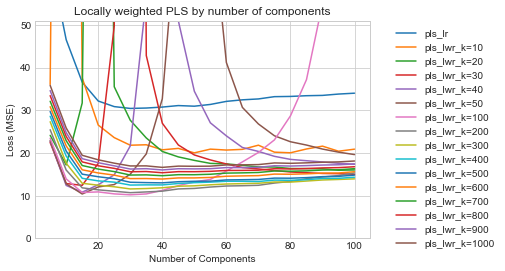

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Locally weighted PLS by number of components")
#ax.plot(x_ls,y_ls,label="lr")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["MSE"],label = f"{name}")
ax.set_ylim(0,max_value)
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"summary_pls.png",bbox_inches='tight')

ax.set_ylim(0,5*min_value)
plt.savefig(log_dir / f"summary_pls_compressed.png",bbox_inches='tight')


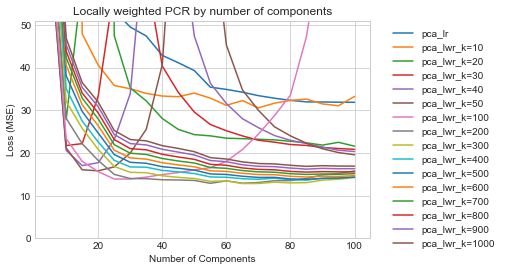

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Locally weighted PCR by number of components")
#ax.plot(x_ls,y_ls,label="lr")

series_labels = scores_df_pcr['model'].unique()
for name in series_labels:
    subset = scores_df_pcr[scores_df_pcr["model"]==name]
    ax.plot(subset["n_comp"],subset["MSE"],label = f"{name}")
ax.set_ylim(0,max_value)
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"summary_pca.png",bbox_inches='tight')

ax.set_ylim(0,5*min_value)
plt.savefig(log_dir / f"summary_pca_compressed.png",bbox_inches='tight')


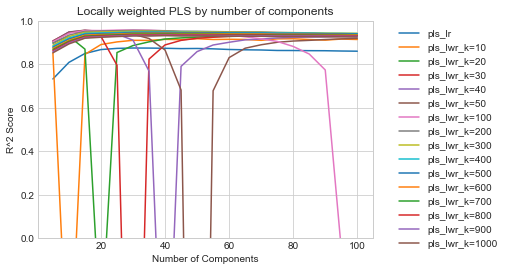

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("R^2 Score")
ax.set_title("Locally weighted PLS by number of components")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["R2"],label = f"{name}")


ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_pls.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_pls_v2.png",bbox_inches='tight')

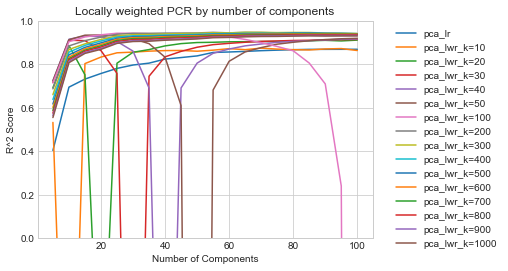

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("R^2 Score")
ax.set_title("Locally weighted PCR by number of components")

series_labels = scores_df_pcr['model'].unique()
for name in series_labels:
    subset = scores_df_pcr[scores_df_pcr["model"]==name]
    ax.plot(subset["n_comp"],subset["R2"],label = f"{name}")


ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_pcr.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_pcr_v2.png",bbox_inches='tight')


In [15]:
#https://stackoverflow.com/questions/22521382/nonlinear-colormap-matplotlib

class nlcmap(object):
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self.transformed_levels = np.linspace(self.levmin, self.levmax, #uniform spacing along levels (colour segments)
             len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self.transformed_levels)
        return self.cmap((yi-self.levmin) / (self.levmax-self.levmin), alpha)

In [16]:
levels = np.concatenate((
    [0, 1],
    [0.6,0.8,0.9,0.95,0.98]
    ))

levels = levels[levels <= 1]
levels.sort()
print(levels)
cmap_nonlin = nlcmap(plt.cm.YlGnBu, levels)

[0.   0.6  0.8  0.9  0.95 0.98 1.  ]


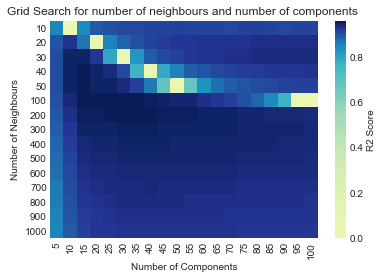

In [17]:
subset = scores_df_pls[["model","n_comp","R2"]]
subset = subset[np.logical_not(subset["model"]=="pls_lr")]
trans = subset["model"].transform(lambda x: int(x.replace("pls_lwr_k=",""))).tolist()

subset.loc[:,"model"]=trans
subset=subset.sort_values("model",ascending=False)
wide = subset.pivot(index = "model",columns= "n_comp",values="R2")

ax = sns.heatmap(wide, linewidth=0.0,vmin=0,center=0,cbar_kws={'label':"R2 Score"},cmap=cmap_nonlin)

ax.set_title("Grid Search for number of neighbours and number of components ")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Number of Neighbours")

plt.savefig(log_dir/"pls_heatmap.png", bbox_inches='tight')

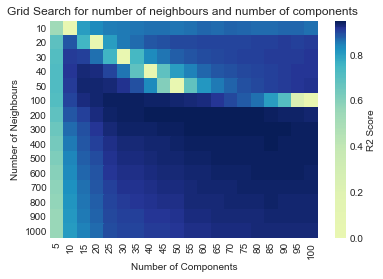

In [18]:
subset = scores_df_pcr[["model","n_comp","R2"]]
subset = subset[np.logical_not(subset["model"]=="pca_lr")]
trans = subset["model"].transform(lambda x: int(x.replace("pca_lwr_k=",""))).tolist()

subset.loc[:,"model"]=trans
subset=subset.sort_values("model",ascending=False)
wide = subset.pivot(index = "model",columns= "n_comp",values="R2")

ax = sns.heatmap(wide, linewidth=0.0,vmin=0,center=0,cbar_kws={'label':"R2 Score"},cmap=cmap_nonlin)

ax.set_title("Grid Search for number of neighbours and number of components ")
ax.set_xlabel("Number of Components")
ax.set_ylabel("Number of Neighbours")

plt.savefig(log_dir/"pca_heatmap.png", bbox_inches='tight')